# Retrospective study on human movement and dengue transmission
This study will focus on examining the daily movement between the 323 URA-demarcated subzones and its relation to the location and severity of dengue hotspots in Singapore. 

Datasets
* Starhub customer location data
* Data.gov.sg daily updated dengue data

Content
1. Data cleaning and preprocessing
2. Exploration (via visualisation of nodes)
3. Feature generation
4. Visualisation using Gephi and Qgis
5. Model building

## Preprocessing
Includes
* extracting coordinate data from shapefiles and writing into CSV (to eliminate excessive work)
* generate graphs
    1. main graph of subzones
    2. breeding habitat graph
    3. combined graph

In [1]:
import pandas as pd
import networkx as nx

network_data = pd.read_csv("Data/network_20160511.csv")
subzone_data = pd.read_csv("Data/Processed/subzonedatav5.csv")

# dropping of within-subzone movements
network_data = network_data.drop(network_data[network_data.Source == network_data.Target].index)

# normalizing flow rates by maximum
network_data['Weight'] = network_data['Weight'].astype(float)
network_data['Weight_norm_by_max'] = (network_data['Weight'] - min(network_data['Weight'])) /\
                                    (max(network_data['Weight']) - min(network_data['Weight']))

subset = network_data[["Source", "Target", "Weight_norm_by_max"]]
edge_list = [tuple(x) for x in subset.values]

#make graph
graph = nx.DiGraph()

Before we can explore the data properly, we should obtain the more data about the subzones such as:
- coordinates (shapefile)
- area (shapefile)
- population (singstats)

pyshp will be used to extract data from the shapefiles.

In [2]:
from shape import *

geo_info_list = sorted(open_shape('shape/subzone.shp'))

print geo_info_list

[('Admiralty', 103.8254828, 1.452254864, 1.2678233233833636), ('Airport Road', 103.8977353, 1.352038409, 0.4969026039741493), ('Alexandra Hill', 103.8088676, 1.2877747265, 1.0353530017485264), ('Alexandra North', 103.82079415, 1.292470169, 0.29512538163786306), ('Aljunied', 103.88352485, 1.3137638425, 2.97368052370417), ('Anak Bukit', 103.77125785000001, 1.337743053, 2.7817625823261825), ('Anchorvale', 103.88871105, 1.393893125, 1.5064086884463541), ('Ang Mo Kio Town Centre', 103.84721355, 1.3730629405, 0.3184235303006517), ('Anson', 103.8437544, 1.2741290809999999, 0.10373656647610005), ('Balestier', 103.85146465, 1.324511639, 1.9359494881998127), ('Bangkit', 103.77419225, 1.3772382570000001, 0.7668942195514774), ('Bayfront Subzone', 103.85840125, 1.2829658575, 0.5237166361103027), ('Bayshore', 103.94863674999999, 1.3140862715, 2.5627887967974856), ('Bedok North', 103.9356975, 1.3297659204999999, 3.219167983389798), ('Bedok Reservoir', 103.92914505, 1.340509488, 2.3908588348051034), (

List will be sorted and added to the sorted data frame. (CSV file already contains lon, lat, area from prior preprocessing session)


In [3]:
# make digraph

# add edgelist
graph.add_weighted_edges_from(edge_list)

# add node attributes
subset = subzone_data["subzone"]
weight_set = subzone_data["cases"]
normweight_set = subzone_data["normalize by sum"]
normmaxweight_set = subzone_data["normalize by max"]
lon_set = subzone_data["lon"]
lat_set = subzone_data["lat"]
area_set = subzone_data["area"]
pop_set = subzone_data["population"]
popdense_set = subzone_data["pop_density"]

for i, subzone in enumerate(subset):
    graph.add_node(subzone, weight = float(weight_set[i]), \
                    normweightsum = float(normweight_set[i]),\
                    normweightmax = float(normmaxweight_set[i]), \
                    longitude = float(lon_set[i]),\
                    latitude = float(lat_set[i]),\
                    type_ = float(5 + 10*normmaxweight_set[i]),\
                    area = float(area_set[i]),\
                    population = float(pop_set[i]),\
                    popdensity = float(popdense_set[i]),\
                    hotspot = 1)

print nx.info(graph)

# export graph to gephi

nx.write_gexf(graph, "notebook_wo_features.gexf")

Name: 
Type: DiGraph
Number of nodes: 323
Number of edges: 84410
Average in degree: 261.3313
Average out degree: 261.3313


## Data Exploration
Using matplotlib to eyeball general data for any significant trends.
* population density has no clear correlation with chance of being an active hotspot
* 

Gephi displays are attached in zip file

In [4]:
# label active hotspots
for node in graph.nodes():
    if graph.node[node]['weight']:
        graph.node[node]['active_hotspot'] = 1
    else:
        graph.node[node]['active_hotspot'] = 0
y = []
for node in graph.nodes():
    y.append(graph.node[node]['active_hotspot'])

population_density = []
for node in graph.nodes():
    population_density.append(graph.node[node]['popdensity'])

population = []
for node in graph.nodes():
    population.append(graph.node[node]['population'])



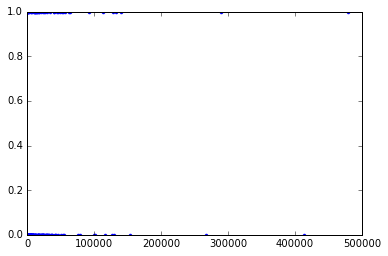

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(population_density, y, '.')
plt.show()

### Looking at Centrality, Pagerank and HITS score

To better understand the humans movement on each subzone, various scores are computed:
* betweenness centrality
* eigenvector centrality
* weighted Pagerank
* HITS (hub and authority score)

All these were added to the node attributes as possible features.

Note: GraphGenerator object will be used to obtain the fully-processed combined, main and breeding habitat graphs

#### Betweenness Centrality
From the plot, lower eigenvector centrality is usually associated with the hotspot being passive. 

#### Eigenvector Centrality

#### Pagerank

#### HITS


In [6]:
import pandas as pd
from graph import *
from features import *
GG = GraphGenerator(network_data, subzone_data)

# get 3 main graphs from 
CG, G, BH = GG.get_graphs()

FB = FeatureBuilder(CG, G, BH)
X, y = FB.get_features_wo_change()

new_X = X
df = pd.DataFrame(new_X)

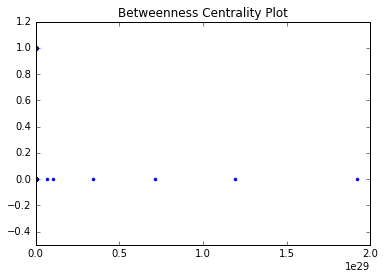

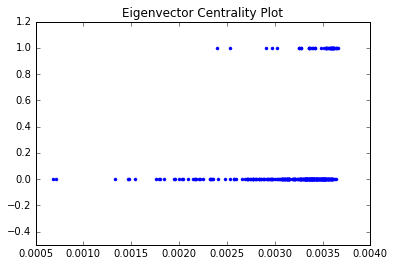

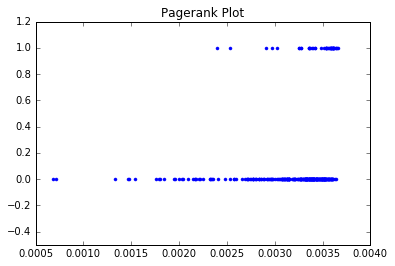

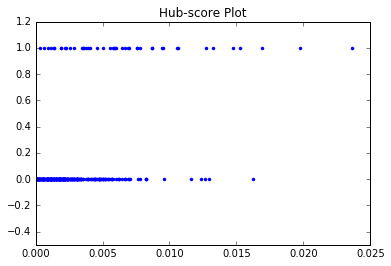

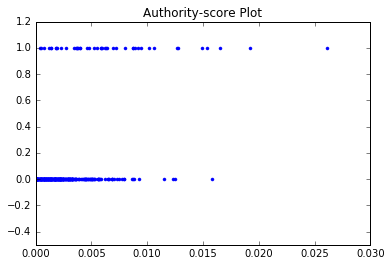

In [7]:
plt.title("Betweenness Centrality Plot")
plt.plot(df[1], y, '.')
plt.ylim((-0.5,1.2))
#plt.xlim((-0.9, 1.1))
plt.show()


plt.title("Eigenvector Centrality Plot")
plt.plot(df[2], y, '.')
plt.ylim((-0.5,1.2))
#plt.xlim((-0.9, 1.1))
plt.show()

plt.title("Pagerank Plot")
plt.plot(df[2], y, '.')
plt.ylim((-0.5,1.2))
#plt.xlim((-0.9, 1.1))
plt.show()

plt.title("Hub-score Plot")
plt.plot(df[3], y, '.')
plt.ylim((-0.5,1.2))
#plt.xlim((-0.9, 1.1))
plt.show()

plt.title("Authority-score Plot")
plt.plot(df[4], y, '.')
plt.ylim((-0.5,1.2))
#plt.xlim((-0.9, 1.1))
plt.show()

## Feature Building

### 1. Effects of nearby Breeding Habitat (BH)
In order to incorporate the breeding habitat location data, two new features were built:
* Breeding habitat density (BHD) (count of BH wihtin 2km radius)
* Breeding habitat proximity (BHP) is the reciprocal of sum of distance for 10 nearest breeding habitat



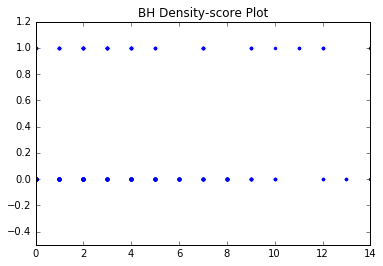

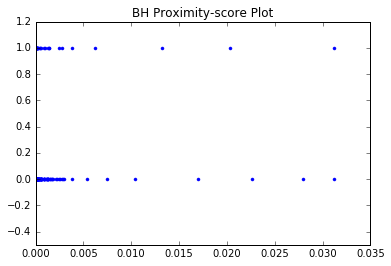

In [8]:
plt.title("BH Density-score Plot")
plt.plot(df[7], y, '.')
plt.ylim((-0.5,1.2))
plt.show()

plt.title("BH Proximity-score Plot")
plt.plot(df[8], y, '.')
plt.ylim((-0.5,1.2))
plt.show()


### 2. Neighbouring effects
Bad Neighbours refers to the sources(S) that have high amount of dengue cases and send sizeable amount of people to the target(T) or targets which have high breeding habitat density which might be a factor in dengue outbreaks.

#### a. Bad Neighbour In

This refers to the effects of neighbouring active subzones sending high volume of people to subzone i.

$$ BNI_{i} = w_{ji} * C_{i} *  e^{d_{ij}}$$
where $$w_{ji} = \frac{f_{ji}}{\sum_{k=1}^{N} f_{ki}} $$

N refers to the total number of nodes in the system. f refers to the normalised edge frequency and C refers to the case number at subzone i.

#### b. Bad Neighbour Out

This refers to the effects of neighbouring BH-dense subzones infecting people that subzone i sent out. The underlying assumption is that the outgoing people from subzone i will return to subzone i as their "home".

$$BNO_{i} = \sum_{j=1}^{N} w_{ij} * e^{BHD_{j}/BHP_{j}}$$
where $$w_{ij} = \frac{f_{ij}}{\sum_{k=1}^{N} f_{ik}} $$


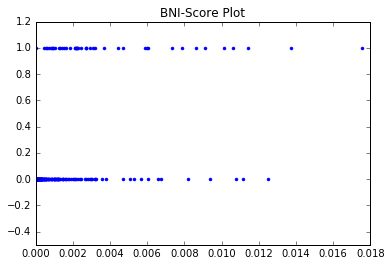

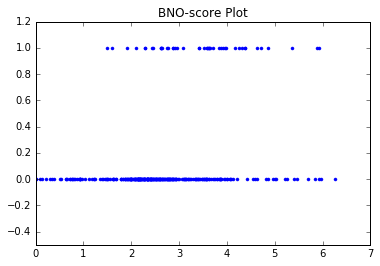

In [9]:

plt.title("BNI-Score Plot")
plt.plot(df[9], y, '.')
plt.ylim((-0.5,1.2))
plt.show()

plt.title("BNO-score Plot")
plt.plot(df[10], y, '.')
plt.ylim((-0.5,1.2))
plt.show()

### 2. 2nd Order Neighbouring effects
From source to target, the path may not be direct, hence the cellular data may be unable to capture the human flow from source to target via an intermediate subzone. In order to close the "triangle", the weighted sum of BNI/BNO from of the target's possible sources will be calculated. 

#### a. Bad Neighbour In (2nd order)
This refers to the effects of neighbouring subzones being an "middleman" for their neighbouring active subzone in redirecting people.

For example, Punggol be receiving high incoming traffic from Pasir-ris but low incoming traffic from Sengkang. However Sengkang has a high outflow to Pasir-ris. Hence by taking into account a neighbour's neighbour, we can close up more of the gap in tracking human flow.

$$BNI2_{i} = \sum_{j=1}^{N} w_{ji} * (BNI_{j} - w_{ij} * C_{i} *  e^{d_{ij}})$$


#### b. Bad Neighbour Out (2nd order)
This refers to BNO's effect but taken a step further to include every neighbour of the target subzone's neighbour.



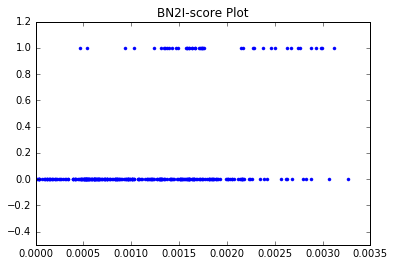

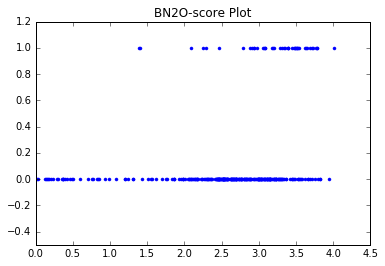

In [10]:
plt.title("BN2I-score Plot")
plt.plot(df[11], y, '.')
plt.ylim((-0.5,1.2))
plt.show()

plt.title("BN2O-score Plot")
plt.plot(df[12], y, '.')
plt.ylim((-0.5,1.2))
plt.show()

### 3. Weekday-Weekend Change
The change in hub and authority score of each subzone from weekday to weekend is able to reflect some nature of the subzone, whether the subzone is a residential area, industrial area or workplace.




In [11]:
GG2 = GraphGenerator(wkend_network_data, subzone_data)
WG, WOG, WBH = GG2.get_graphs()
FB2 = FeatureBuilder(WG, WOG, WBH)
FB.set_weekend_change(FB2.OG)
X, y = FB.get_features()

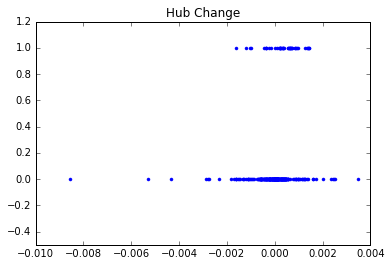

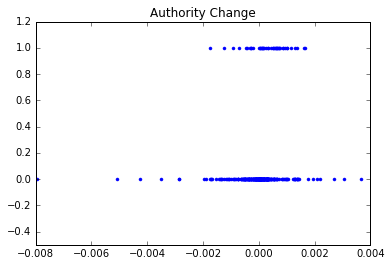

In [12]:
df2 = pd.DataFrame(X)

plt.title("Hub Change")
plt.plot(df2[13], y, '.')
plt.ylim((-0.5,1.2))
plt.show()

plt.title("Authority Change")
plt.plot(df2[14], y, '.')
plt.ylim((-0.5,1.2))
plt.show()

## Model Building
A series of supervised learning models will be used to try and accurately classify the subzones by their hotspot activity. The reason for this is to try and understand which features are good identifiers of active hotspots, hence future hotspots can be identified before the situation gets worse.

#### Model types
* DummyClassifier - baseline estimator, if selecting the majority to be the "True"
* LogisticRegression
* Linear Support Vector Classifier(SVC)
* SVC with radial basis function (rbf) kernel
* RandomForestClassifier
* ExtraTreesClassifier
* KNearestClassifier
* GradientBoostingClassifier

#### Data Scaling
sklearn.prepreocessing.MinMaxScaler was used to scale all numerical data prior to fitting to prevent larger features from overpowering numerically smaller variables.

#### Feature Selection
sklearn.feature_selection.SelectPercentile was used to reduce the feature set and improve training time.

#### Pipeline
Pipeline was built to fit scaler, feature selection and model, allowing room for more modular and flexible testing of custome features.

#### Model Tuning
Models were tuned using sklearn.grid_search.GridSearchCV with the following parameters:
* 4-fold cross validation (to accommodate the small sample size)
* 'f1_macro' scoring 
* weight_class = 'balanced' was set for all Classifiers except KNearestClassifier and GradientBoostingClassifier.


In [13]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.pipeline import Pipeline

# Example of SVC pipeline
def svc_model():
    select = SelectPercentile(score_func=chi2, percentile=21) #gridsearched
    svc = SVC(class_weight='balanced', gamma=0, kernel='rbf', C=0.25, tol=0.1)  #gridsearched
    scaler = MinMaxScaler()
    pipeline = Pipeline([('scale', scaler), ('select', select),('svc', svc)])
    return pipeline

#### Cross-Validating
4-fold CV is done using an "f1_macro" scoring which is takes the average f1 scores of both labels (passive and active). This scorer achieves the highest score differece between the DummyClassifier and the other learning models, hence is believed to be a good choice when scoring unbalanced data set (85.7% False). 

"f1" scorer focuses on label 1 (True) and resulted in high number of False predictions while "f1_weighted" amplified the imbalanceness by taking the respective label proportions as weights in averaging the 2 f1 scores.



In [14]:
from train import *
apply_model(X, y)

Dummy
CV score(f1_macro): 0.4615 (+/- 0.00)
Classification Report:
             precision    recall  f1-score   support

          0       0.81      1.00      0.89        51
          1       0.00      0.00      0.00        12

avg / total       0.66      0.81      0.72        63

Confusion Matrix:
[[51  0]
 [12  0]]
 
 
LogisticRegression
CV score(f1_macro): 0.7286 (+/- 0.11)
Classification Report:
             precision    recall  f1-score   support

          0       0.98      0.82      0.89        51
          1       0.55      0.92      0.69        12

avg / total       0.90      0.84      0.85        63

Confusion Matrix:
[[42  9]
 [ 1 11]]
 
 
LinearSVC
CV score(f1_macro): 0.7366 (+/- 0.08)
Classification Report:
             precision    recall  f1-score   support

          0       0.98      0.82      0.89        51
          1       0.55      0.92      0.69        12

avg / total       0.90      0.84      0.85        63

Confusion Matrix:
[[42  9]
 [ 1 11]]
 
 
SVC w rbf
CV s

#### Feature Importance
Features are ranked accordingly by using a RandomForestClassifier's feature__importances_ attribute.

The top 5 feature in terms of importances are the BNI-score, normalised population, HITS (both hub and authority) and eigenvector centrality. 

Feature 1 is edge-weighted betweenness centrality.

1. Feature 9 (0.147468)
2. Feature 5 (0.114478)
3. Feature 3 (0.080475)
4. Feature 4 (0.077339)
5. Feature 0 (0.076805)
6. Feature 11 (0.074704)
7. Feature 6 (0.068083)
8. Feature 12 (0.067534)
9. Feature 2 (0.056133)
10. Feature 10 (0.055762)
11. Feature 13 (0.047725)
12. Feature 7 (0.044192)
13. Feature 14 (0.043877)
14. Feature 8 (0.041411)
15. Feature 1 (0.004013)


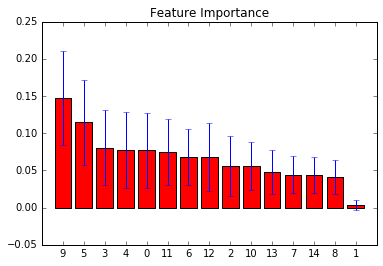

In [15]:
feature_rank(X,y)

## Gephi Charts

7 of the more important graphs are plotted to reveal some insights regarding the problem. 
For graph 1-6, pink represent passive subzones while green represent active hotspots.
Size of the subzone will vary with the corresponding feature strenght.

### Graph 1 - Eigenvector Centrality
* No active subzones have a low EC whereas passive subzones vary in EC levels. 
* High EC may be a criteria for cases to appear since it represents the influence of the node on the network.

### Graph 2 - Hub score (HITS)
* From the graph, the relationship between hub score and dengue activity can be seen as most of the larger circles, representing subzones with high hub score, are have reported cases of dengue victims.


### Graph 3 - Breeding Habitat Proximity
* There is a weak relationship between BHP and dengue activity from the graph.
* 3 noticeably large subzones (w.r.t BHP) have zero reported dengue cases however this could perhaps be a warning sign for possible cases in the future.

### Graph 4 - Bad Neighbour (In) effect
* There is an observable and strong correlation between the dengue activity and the BNI-score. This supports the reasoning that if your close neighbouring nodes are active, there is tendency for the dengue activity to spread to you. Note: "close" refers to distance and/or in-flow.
* 

### Graph 5 - 2nd Order Bad Neighbour (In) effect
* There is an weaker correlation between dengue activity and BN2I score as compared to BNI. Nonetheless, having a higher BN2I score 

### Graph 6 - Bad Neighbour (Out) effect
* There is a correlation between dengue activity and BNO score as a subzone with higher BNO score (circle size) tends to be an active subzone.

### Graph 7 - Hub score change
* color scale - purple (negative) to white (neutral) to green (positive)
* size - number of case
* From the graph, all active subzones experienced an increase in hub score, which means there is a higher outflow of people from the subzones in the weekend compared to weekdays.
* 